In [1]:
dataset_name = 'EMOPain'

In [2]:
import os
import zipfile
import urllib.request
from pathlib import Path

from genrie.utils.path_lib import EXAMPLES_PATH

EXAMPLES_DATA_PATH = Path(EXAMPLES_PATH, 'data')
os.makedirs(EXAMPLES_DATA_PATH, exist_ok=True)

DATA_URL = f'http://www.timeseriesclassification.com/aeon-toolkit/{dataset_name}.zip'
ZIP_PATH = Path(EXAMPLES_DATA_PATH, f'{dataset_name}.zip')
DATA_PATH = Path(EXAMPLES_DATA_PATH, f'{dataset_name}')

if not os.path.exists(DATA_PATH):
    urllib.request.urlretrieve(DATA_URL, ZIP_PATH)
    zipfile.ZipFile(ZIP_PATH).extractall(DATA_PATH)

In [3]:
import numpy as np
import pandas as pd
from sktime.datasets import load_from_tsfile_to_dataframe

x_train, y_train = load_from_tsfile_to_dataframe(str(Path(DATA_PATH, f'{dataset_name}_TRAIN.ts')), return_separate_X_and_y=True)
x_test, y_test = load_from_tsfile_to_dataframe(str(Path(DATA_PATH, f'{dataset_name}_TEST.ts')), return_separate_X_and_y=True)

shuffled_idx = np.arange(x_train.shape[0])
np.random.shuffle(shuffled_idx)
if isinstance(x_train, pd.DataFrame):
    x_train = x_train.iloc[shuffled_idx, :]
else:
    x_train = x_train[shuffled_idx, :]
y_train = y_train[shuffled_idx]

if isinstance(x_train.iloc[0, 0], pd.Series):
    def convert(arr):
        return np.array([d.values for d in arr], dtype=float)
    x_train = np.apply_along_axis(convert, 1, x_train)
    x_test = np.apply_along_axis(convert, 1, x_test)


In [4]:
from genrie.data.data_adapter import DataStore

data = DataStore(features=x_test, target=y_test)
data.features.shape, data.target.shape, data.covmats.shape

((355, 30, 200), (355,), (355, 30, 30))

In [5]:
ortho_covmats = data.get_synthetic_covmats(mode='ortho')
noise_covmats = data.get_synthetic_covmats(mode='noise')

In [22]:
from genrie.utils.visualization.plots import plot_covariance_surface

random_sample_id = np.random.randint(low=0, high=data.n_samples)
random_channel_id = np.random.randint(low=0, high=data.n_channels)
plot_covariance_surface(data.covmats[random_sample_id], ortho_covmats[random_sample_id])
plot_covariance_surface(data.covmats[random_sample_id], noise_covmats[random_sample_id])

In [7]:
n_samples, n_channels, ts_length = data.features.shape
latent_dim = 4 * ts_length
n_epochs = 20
batch_size = 6
learning_rate = 0.001

In [13]:
import torch
from torch import nn, optim
from tqdm import tqdm

from genrie.generation.gan import Generator, Discriminator
from genrie.metrics.metric import DistanceMetric

X_tensor = torch.tensor(data.features, dtype=torch.float32)
covmats_tensor = torch.tensor(data.covmats, dtype=torch.float32)

generator = Generator(latent_dim, n_channels, ts_length)
discriminator = Discriminator(n_channels, ts_length)
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

pbar = tqdm(range(n_epochs))

for epoch in pbar:
    for i in range(0, n_samples, batch_size):
        real_samples = X_tensor[i:i + batch_size]
        real_covmats = covmats_tensor[i:i + batch_size]

        valid = torch.ones(real_samples.size(0), 1)
        fake = torch.zeros(real_samples.size(0), 1)

        z = torch.randn(real_samples.size(0), latent_dim)  # Random noise
        gen_samples = generator(z, real_covmats)  # Generate fake samples

        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_samples, real_covmats), valid)
        fake_loss = adversarial_loss(discriminator(gen_samples.detach(), real_covmats), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(gen_samples, real_covmats), valid)
        g_loss.backward()
        optimizer_G.step()

    pbar.write(f'D-Loss: {d_loss.item():.4f}, G-Loss: {g_loss.item():.4f}')
pbar.close()

  5%|▌         | 1/20 [00:01<00:21,  1.15s/it]

D-Loss: 3.1995, G-Loss: 0.9280


 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

D-Loss: 1.3554, G-Loss: 0.9123


 15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

D-Loss: 1.4184, G-Loss: 1.2913


 20%|██        | 4/20 [00:04<00:16,  1.05s/it]

D-Loss: 1.1874, G-Loss: 0.8250


 25%|██▌       | 5/20 [00:05<00:15,  1.02s/it]

D-Loss: 1.4086, G-Loss: 7.5264


 30%|███       | 6/20 [00:06<00:14,  1.00s/it]

D-Loss: 1.4265, G-Loss: 0.7152


 35%|███▌      | 7/20 [00:07<00:12,  1.00it/s]

D-Loss: 1.3836, G-Loss: 0.7524


 40%|████      | 8/20 [00:08<00:11,  1.02it/s]

D-Loss: 1.3052, G-Loss: 0.9826


 45%|████▌     | 9/20 [00:09<00:10,  1.04it/s]

D-Loss: 1.3754, G-Loss: 1.2069


 50%|█████     | 10/20 [00:10<00:09,  1.04it/s]

D-Loss: 1.3945, G-Loss: 0.8110


 55%|█████▌    | 11/20 [00:11<00:08,  1.03it/s]

D-Loss: 1.3392, G-Loss: 0.7909


 60%|██████    | 12/20 [00:12<00:07,  1.01it/s]

D-Loss: 1.2723, G-Loss: 1.0052


 65%|██████▌   | 13/20 [00:12<00:06,  1.03it/s]

D-Loss: 1.0428, G-Loss: 1.0739


 70%|███████   | 14/20 [00:13<00:05,  1.04it/s]

D-Loss: 0.7839, G-Loss: 1.2268


 75%|███████▌  | 15/20 [00:14<00:04,  1.05it/s]

D-Loss: 1.4484, G-Loss: 0.8514


 80%|████████  | 16/20 [00:15<00:03,  1.06it/s]

D-Loss: 1.4243, G-Loss: 0.7322


 85%|████████▌ | 17/20 [00:16<00:02,  1.06it/s]

D-Loss: 0.9656, G-Loss: 0.8563


 90%|█████████ | 18/20 [00:17<00:01,  1.05it/s]

D-Loss: 1.1404, G-Loss: 0.6035


 95%|█████████▌| 19/20 [00:18<00:00,  1.03it/s]

D-Loss: 0.7061, G-Loss: 0.9025


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]

D-Loss: 0.8803, G-Loss: 0.8498


In [16]:
ortho_samples = np.zeros(data.features.shape)

for i, ortho_matrix in enumerate(ortho_covmats):
    with torch.no_grad():
        new_covmat = torch.tensor(ortho_matrix, dtype=torch.float32)
        z = torch.randn(1, latent_dim)
        generated_sample = generator(z, new_covmat.unsqueeze(0)).detach().numpy()
        ortho_samples[i] = generated_sample

print(DistanceMetric()(data.features, ortho_samples))

{'onnd': array(28.024387, dtype=float32), 'innd': array(46215.527, dtype=float32)}


In [17]:
noise_samples = np.zeros(data.features.shape)

for i, ortho_matrix in enumerate(noise_covmats):
    with torch.no_grad():
        new_covmat = torch.tensor(ortho_matrix, dtype=torch.float32)
        z = torch.randn(1, latent_dim)
        generated_sample = generator(z, new_covmat.unsqueeze(0)).detach().numpy()
        noise_samples[i] = generated_sample

print(DistanceMetric()(data.features, noise_samples))

{'onnd': array(1.6412147, dtype=float32), 'innd': array(1.7114072, dtype=float32)}


In [23]:
from genrie.utils.visualization.plots import plot_spectral_embeddings_comparison
plot_spectral_embeddings_comparison(data.features, ortho_samples, data.spd_space, data.shrinkage)

In [24]:
from genrie.utils.visualization.plots import plot_spectral_embeddings_comparison
plot_spectral_embeddings_comparison(data.features, noise_samples, data.spd_space, data.shrinkage)

In [25]:
from genrie.utils.visualization.plots import plot_pca_comparison
plot_pca_comparison(data.features, ortho_samples)

In [26]:
from genrie.utils.visualization.plots import plot_pca_comparison
plot_pca_comparison(data.features, noise_samples)

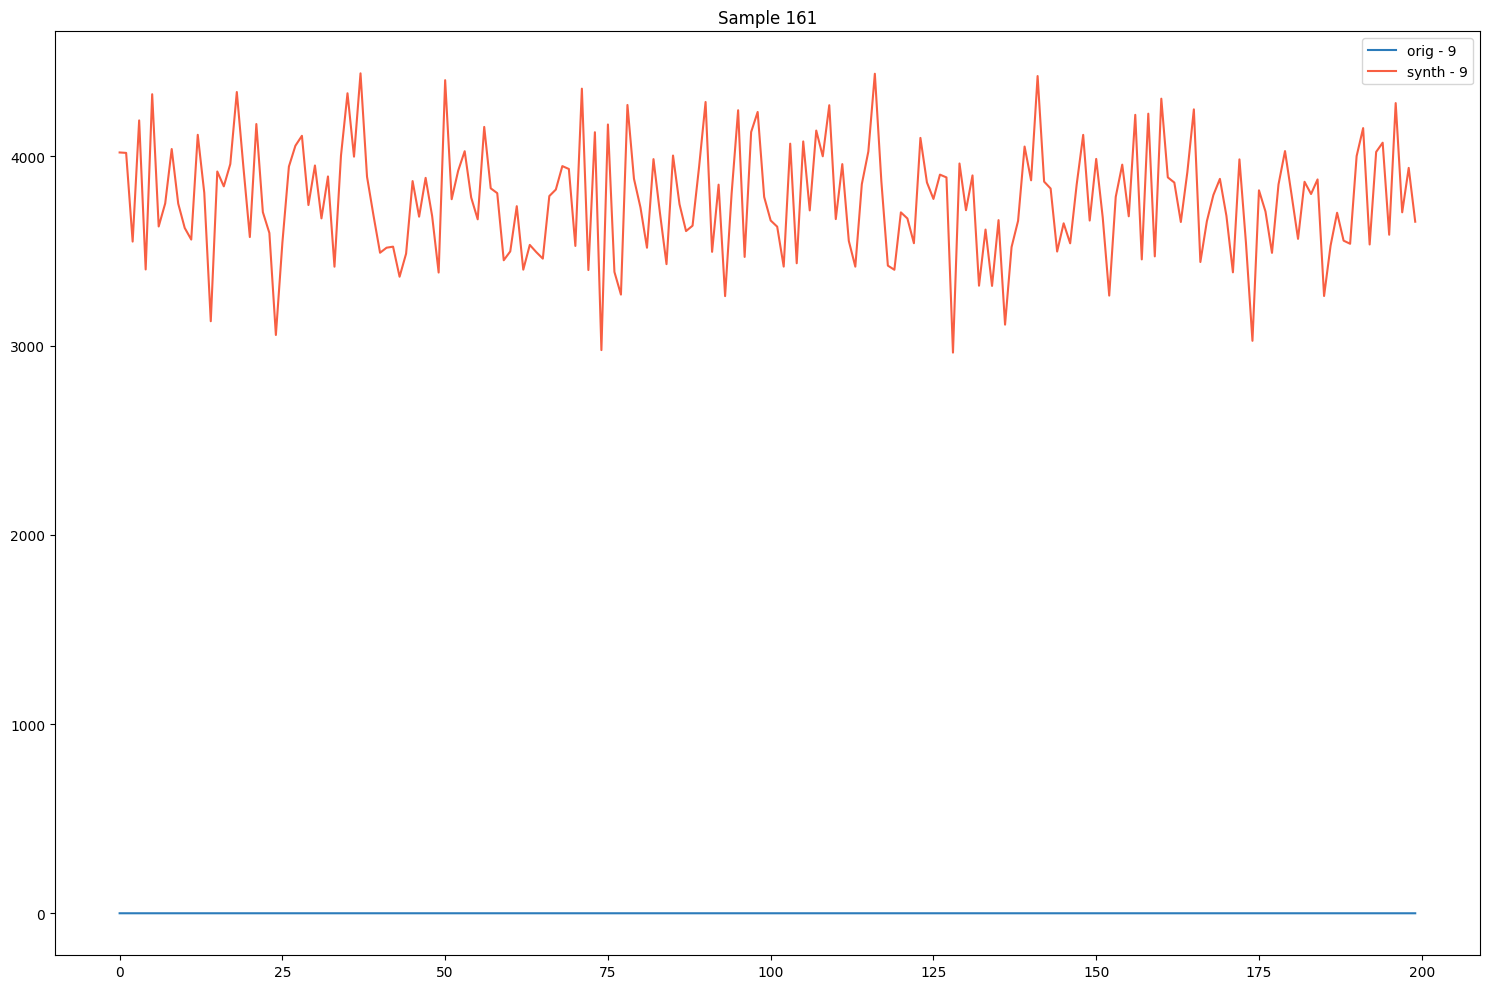

In [27]:
from genrie.utils.visualization.plots import plot_multivariate_data_comparison
plot_multivariate_data_comparison(data.features, ortho_samples, random_sample_id, [random_channel_id])

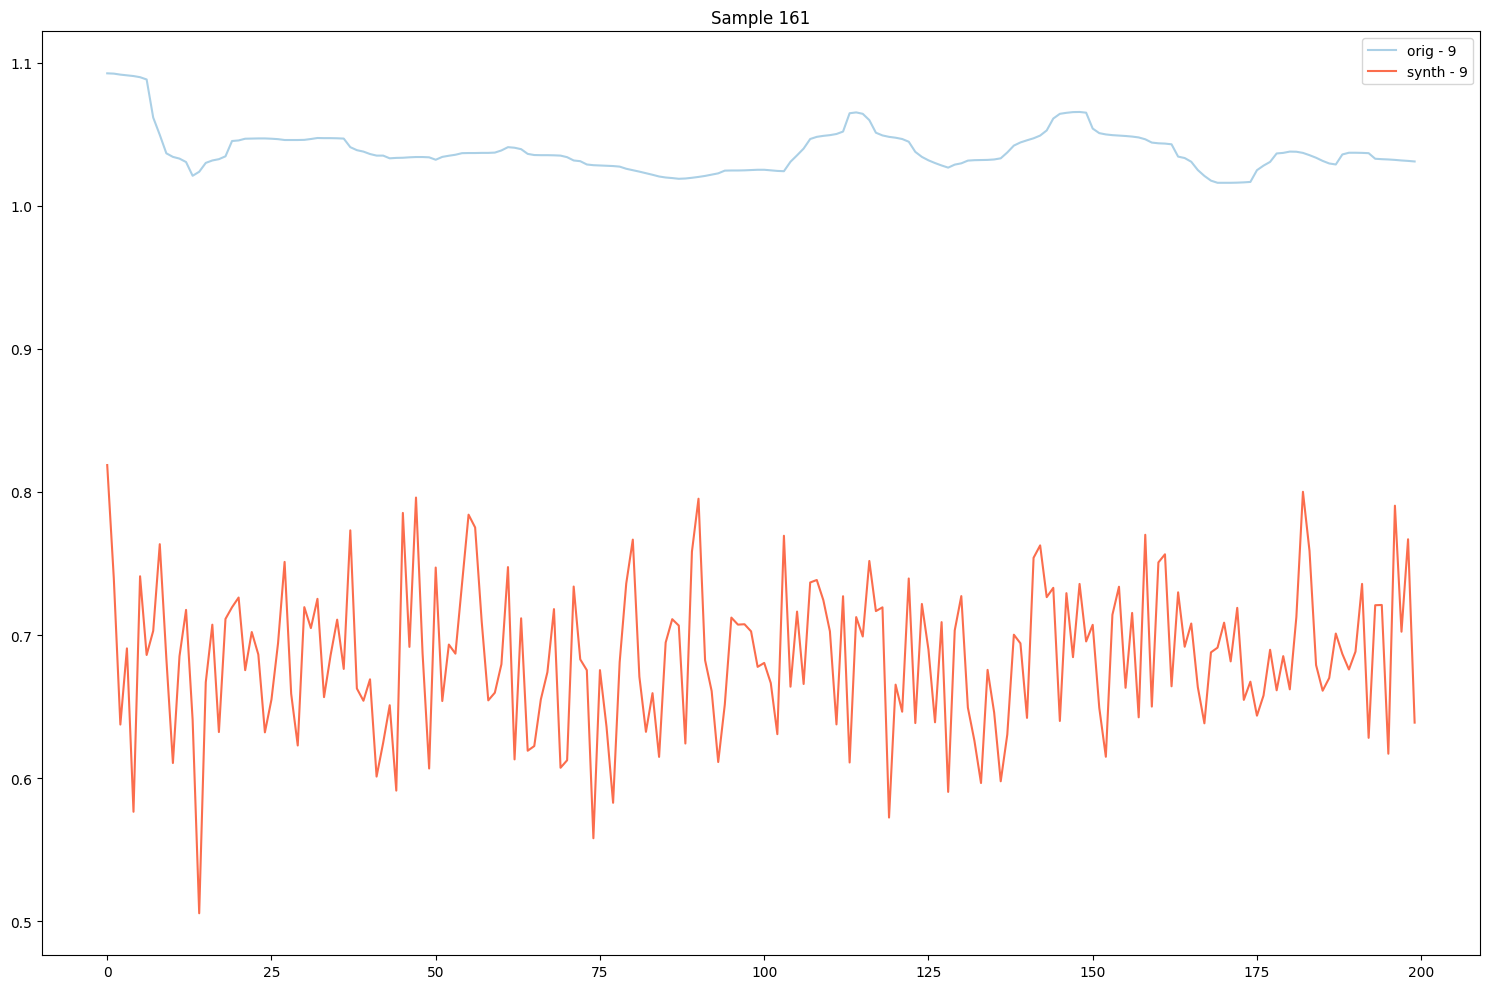

In [28]:
from genrie.utils.visualization.plots import plot_multivariate_data_comparison
plot_multivariate_data_comparison(data.features, noise_samples, random_sample_id, [random_channel_id])